In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

# Solução 2020-10-24

                 Mean       Std        Acc
SVC         82.998826  3.387714  79.888268
Log_Reg     79.066901  4.175341  79.888268
Grad_Boost  81.175665  3.960213  82.122905


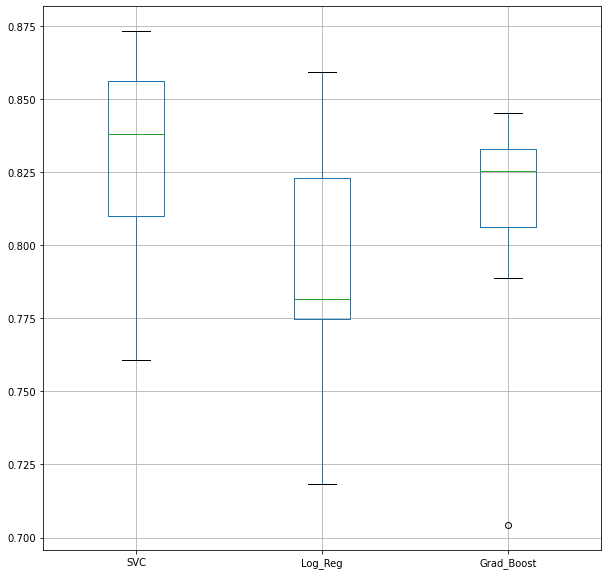

In [62]:
TEST_SIZE = 0.2
RANDOM_SEED = 42
STRATEGY_NUM = 'mean'
STRATEGY_CAT = 'most_frequent'
SCORING = 'accuracy'
N_SPLITS = 10
USE_COLS = ['PassengerId','Survived','Pclass','Sex','Age','Embarked']
NUM_FEAT = ['Pclass','Age']
CAT_FEAT = ['Sex','Embarked']

df_titanic = pd.read_csv('./data/train.csv',index_col='PassengerId',usecols=USE_COLS)

X = df_titanic.drop(columns='Survived')
y = df_titanic.loc[:,'Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Imputers and scalers
ohe = OneHotEncoder()
num_imputer = SimpleImputer(strategy=STRATEGY_NUM)
cat_imputer = SimpleImputer(strategy=STRATEGY_CAT)
scaler = StandardScaler()

# pipe numeric and cat
num_transf = Pipeline([('Num_mputer', num_imputer), ('Scaler', scaler)])
cat_transf = Pipeline([('Cat_Imputer', cat_imputer), ('OneHot', ohe)])

# preprocessador
preprocessor = ColumnTransformer(transformers=[
    ('Numeric', num_transf, NUM_FEAT),
    ('Categoric', cat_transf, CAT_FEAT)
])

svc = SVC(random_state=RANDOM_SEED)
log_reg = LogisticRegression(random_state=RANDOM_SEED)
grad_boost = GradientBoostingClassifier(random_state=RANDOM_SEED)
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# list models
list_models = [('SVC', svc), ('Log_Reg', log_reg), ('Grad_Boost', grad_boost)]

df_summary = pd.DataFrame(columns=['Mean','Std','Acc'])
df_scores = pd.DataFrame()

X_final  = pd.read_csv("./data/test.csv",index_col='PassengerId',usecols=['PassengerId','Pclass','Sex','Age','Embarked'])

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    df_summary.loc[name] = [scores.mean()*100, 
                            scores.std()*100,
                           accuracy_score(y_test, y_pred)*100]
    
    y_pred_final = pipe.predict(X_final)
    output = pd.DataFrame({'PassengerId': X_final.index, 'Survived': y_pred_final})
    output.to_csv(f'{name} Titanic 2020-10-24.csv',index=False)

print(df_summary)
df_scores.boxplot(figsize=(10, 10))
plt.show()

In [48]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(f'Acc teste: {accuracy_score(y_test, y_pred)*100:.2f}%')

Acc teste: 82.12%


In [45]:
X

,Pclass,Sex,Age,Embarked
PassengerId,,,,
892,3,male,34.5,Q
893,3,female,47.0,S
894,2,male,62.0,Q
895,3,male,27.0,S
896,3,female,22.0,S
...,...,...,...,...
1305,3,male,NaN,S
1306,1,female,39.0,C
1307,3,male,38.5,S


# Solução Old

In [ ]:
TEST_SIZE = 0.2
RANDOM_SEED = 42
STRATEGY_NUM = 'mean'
STRATEGY_CAT = 'constant'
SCORING = 'accuracy'
N_SPLITS = 5

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

In [ ]:
tr_data = train_data[['Survived','Sex','Pclass']]
tr_data.loc[:,'Sex'] = tr_data['Sex'].str.replace('female','0').str.replace('male','1')
te_data = test_data[['Sex','Pclass']]
te_data.loc[:,'Sex'] = te_data['Sex'].str.replace('female','0').str.replace('male','1')

In [ ]:
X = tr_data.drop(columns='Survived')
y = tr_data['Survived']

rf_random.fit(X,y)

In [ ]:
te_data.loc[:,'Survived'] = rf_random.predict(te_data)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('Titanic Once again.csv', index=False)

## Soluções Prontas

In [ ]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")